# 8. Lunar Lander problem with Policy Gradients 

_Exercise: Use policy gradients to solve ~OpenAI Gym~ Gymnasium's LunarLander-v3 environment._

[Lunar Lander Documentation](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

In [20]:
import random
import numpy as np
from matplotlib import pyplot as plt

import gymnasium as gym

import keras
import tensorflow as tf

np.random.seed(42)
keras.utils.set_random_seed(42)


In [30]:
def play_step(
    env: gym.Env, model: keras.models.Model, observation, loss_fn: keras.losses.Loss
):
    with tf.GradientTape() as tape:
        y_pred = model(np.expand_dims(observation, axis=0))  # (1, 4)
        y_pred_squeezed = np.squeeze(y_pred)  # remove batch dimension
        predicted_action = random.choices(range(len(y_pred_squeezed)), y_pred_squeezed)
        y_true = np.array(predicted_action)
        # loss_value = tf.reduce_mean(loss_fn(y_true, y_pred))
        loss_value = loss_fn(y_true, y_pred)

    gradient = tape.gradient(loss_value, model.trainable_weights)
    observation, reward, terminated, truncated, info = env.step(predicted_action[0])

    return observation, reward, terminated, truncated, gradient


def play_episode(
    env: gym.Env, n_max_steps, model: keras.models.Model, loss_fn: keras.losses.Loss
):
    rewards = []
    grads = []

    observation, _ = env.reset(seed=42)
    for steps in range(n_max_steps):
        observation, reward, terminated, truncated, gradient = play_step(
            env, model, observation, loss_fn
        )

        rewards.append(reward)
        grads.append(gradient)

        if terminated or truncated:
            break

    return rewards, grads


def play_multiple_episodes(
    env: gym.Env,
    n_episodes_per_update,
    n_max_steps,
    model: keras.models.Model,
    loss_fn: keras.losses.Loss,
):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes_per_update):
        rewards, grads = play_episode(env, n_max_steps, model, loss_fn)
        all_rewards.append(rewards)
        all_grads.append(grads)
    return all_rewards, all_grads


def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted


def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [
        discount_rewards(rewards, discount_factor) for rewards in all_rewards
    ]

    flat_rewards = np.concatenate(all_rewards)
    reward_mean = np.mean(flat_rewards)
    reward_std = np.std(flat_rewards)

    return [
        (discounted_rewards - reward_mean) / reward_std
        for discounted_rewards in all_discounted_rewards
    ]


def play_lunar_lander(
    n_epochs=1000, discount_factor=0.99, n_episodes_per_update=16, n_max_steps=1000
):
    env = gym.make("LunarLander-v3", render_mode="rgb_array")
    if isinstance(env.action_space, gym.spaces.Discrete):
        n_actions = env.action_space.n
    else:
        raise Exception("Action space is not discrete")

    model = keras.models.Sequential()
    model.add(keras.Input(shape=env.observation_space.shape))
    model.add(keras.layers.Dense(32, "relu"))
    model.add(keras.layers.Dense(32, "relu"))
    model.add(keras.layers.Dense(n_actions, "softmax"))

    optimizer = keras.optimizers.Nadam(learning_rate=0.01)
    loss_fn = keras.losses.SparseCategoricalCrossentropy()

    env.reset(seed=42)

    mean_rewards = []

    for epoch in range(n_epochs):
        all_rewards, all_grads = play_multiple_episodes(
            env, n_episodes_per_update, n_max_steps, model, loss_fn
        )

        mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
        print(
            f"\rIteration: {epoch + 1}/{n_epochs}," f" mean rewards: {mean_reward:.1f}",
            end="",
        )
        mean_rewards.append(mean_reward)
        if (mean_reward > 210):
            break

        all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)

        all_mean_grads = []
        for var_index in range(len(model.trainable_variables)):
            mean_grads = tf.reduce_mean(
                [
                    final_reward * all_grads[episode][step][var_index]
                    for episode, final_rewards in enumerate(all_final_rewards)
                    for step, final_reward in enumerate(final_rewards)
                ],
                axis=0,
            )
            all_mean_grads.append(mean_grads)

        optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

    env.close()

    return model, mean_rewards


model, mean_rewards = play_lunar_lander()

Iteration: 119/1000, mean rewards: 230.1

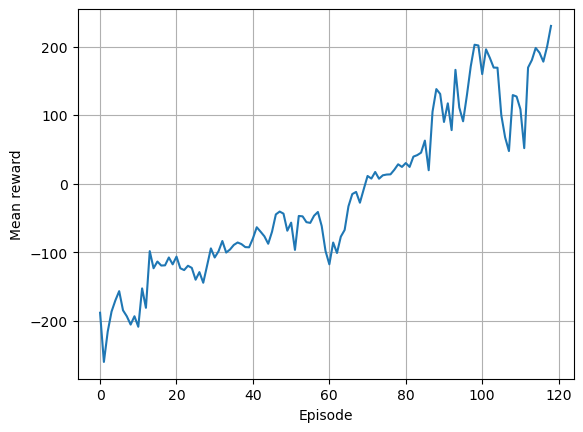

In [31]:
plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.grid()
plt.show()

In [35]:
env = gym.make("LunarLander-v3", render_mode="human")
observation, info = env.reset(seed=42)
for _ in range(1000):
    y_pred = model(np.expand_dims(observation, axis=0))  # (1, 4)
    predicted_action = np.argmax(y_pred, axis=-1)

    observation, reward, terminated, truncated, info = env.step(predicted_action[0])

    if terminated or truncated:
        observation, info = env.reset()

env.close()